# Building a Semantic Retrieval System for Book Discovery Using TF-IDF, NMF, and Cosine Similarity

**COSCI210 - Data Mining and Wrangling 1**

**Jose Miguel Bautista, PhD**
  
*Lab Report 2/Final Project*

**<u>MSDS 2026 Learning Team 8, Term 2</u>**

- Francis Erdey M. Capati
   
- Kevin Ansel S. Dy

- Jan Paolo V. Moreno

- Mia Cielo G. Oliveros

## Abstract
This paper presents an end-to-end semantic search pipeline designed to assist bookstore retailers in identifying fiction titles relevant to a customer’s requested themes or topics. Using Penguin Random House’s API as a metadata source, we construct a corpus of fiction titles and apply a multi-stage natural language processing (NLP) workflow. The flap-copy descriptions undergo TF-IDF vectorization, followed by Non-Negative Matrix Factorization (NMF) for topic extraction. A cosine similarity ranking layer enables semantic retrieval, allowing users to submit free-form text queries and receive the most relevant book titles. The resulting system enables accurate, interpretable topic-aligned book recommendations suitable for curation.

## Introduction and Problem Definition

A bookstore customer requests recommendations for titles aligned with specific themes or topics. The objective is to build a semantic retrieval system that returns relevant fiction books from the retailer’s inventory. The challenge is to interpret free-form text queries and identify the most semantically aligned titles using book metadata.

## Data Acquisition from Penguin Random House API

The corpus is constructed from Penguin Random House’s metadata service, accessed via a secure API key.

2.1. Collecting Fiction Category Identifiers

Fiction BISAC categories are retrieved from PRH endpoints and stored locally in a JSON file for reference.

These category IDs form the basis for selecting relevant books to include in the corpus.

2.2. Batch Retrieval of Title Metadata
A custom function accepts:

A list of category IDs

A record count per category

A set of API parameters

The function returns a list of data frames, each containing:

|ISBN|
|--|
|Title|
|Author|
|Flap-copy description|

These fields form the raw text corpus for downstream NLP processing.

In [33]:
import requests
import time
from datetime import datetime, timedelta
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import lru_cache
import json
import bs4
import re
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
API_KEY = "fh5hj47dynk4nvx4s9ewufj4"
BASE = "https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/views/istca"
CAT = "https://api.penguinrandomhouse.com/resources/v2/domains/PRH.US/categories/"
TITLE_CAT = "https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/"
session = requests.Session()

In [34]:
BISAC = pd.read_json("bisac_prefixes.json", typ="series").reset_index()
BISAC.columns = ["prefix", "category"]
BISAC

,prefix,category
0,ANT,Antiques & Collectibles
1,ARC,Architecture
2,BIB,Bibles
3,BIO,Biography & Autobiography
4,BOD,"Body, Mind & Spirit"
5,BUS,Business & Economics
6,CGN,Comics & Graphic Novels
7,COM,Computers
8,CKB,Cooking
9,CRA,Crafts & Hobbies


In [35]:
with open('fiction_BISAC.json', 'r') as f:
    fiction_bisac_codes = json.load(f)
fiction_bisac_codes = fiction_bisac_codes.get('data')
fiction_bisac_codes
f_cat_map = {
    c["catId"]: c["menuText"]
    # c["catId"]: {
    #     "BISAC": c["catUri"],
    #     "Description": c["menuText"]
        for c in fiction_bisac_codes["categories"]
}
f_cat_map

{3000001525: 'Fiction',
 3000001526: 'Absurdist',
 3000001527: 'Action & Adventure',
 3000001528: 'Adaptations & Pastiche',
 3000001529: 'African American & Black',
 3000001530: 'Christian',
 3000001531: 'Erotica',
 3000001532: 'Historical',
 3000001533: 'Mystery & Detective',
 3000001534: 'Urban & Street Lit',
 3000001535: 'Women',
 3000001536: 'Alternative History',
 3000001537: 'Amish & Mennonite',
 3000001538: 'Animals',
 3000001539: 'Anthologies (multiple authors)',
 3000001540: 'Asian American & Pacific Islander',
 3000001541: 'Biographical & Autofiction',
 3000001542: 'Books, Bookstores & Libraries',
 3000001543: 'Buddhist',
 3000001544: 'Christian',
 3000001545: 'Biblical',
 3000001546: 'Classic & Allegory',
 3000001547: 'Collections & Anthologies',
 3000001548: 'Contemporary',
 3000001549: 'Fantasy',
 3000001550: 'Futuristic',
 3000001551: 'Historical',
 3000001552: 'Romance',
 3000001553: 'Historical',
 3000001555: 'Suspense',
 3000001556: 'Western',
 3000001558: 'City Life',

In [86]:
len(f_cat_map)

369

In [91]:
f_cat_id = {}
for key, value in f_cat_map.items():
    if value not in f_cat_id.values():
        f_cat_id[key] = value

f_cat_id

{3000001525: 'Fiction',
 3000001526: 'Absurdist',
 3000001527: 'Action & Adventure',
 3000001528: 'Adaptations & Pastiche',
 3000001529: 'African American & Black',
 3000001530: 'Christian',
 3000001531: 'Erotica',
 3000001532: 'Historical',
 3000001533: 'Mystery & Detective',
 3000001534: 'Urban & Street Lit',
 3000001535: 'Women',
 3000001536: 'Alternative History',
 3000001537: 'Amish & Mennonite',
 3000001538: 'Animals',
 3000001539: 'Anthologies (multiple authors)',
 3000001540: 'Asian American & Pacific Islander',
 3000001541: 'Biographical & Autofiction',
 3000001542: 'Books, Bookstores & Libraries',
 3000001543: 'Buddhist',
 3000001545: 'Biblical',
 3000001546: 'Classic & Allegory',
 3000001547: 'Collections & Anthologies',
 3000001548: 'Contemporary',
 3000001549: 'Fantasy',
 3000001550: 'Futuristic',
 3000001552: 'Romance',
 3000001555: 'Suspense',
 3000001556: 'Western',
 3000001558: 'City Life',
 3000001559: 'Classics',
 3000001560: 'Coming Of Age',
 3000001561: 'Crime',
 3

In [92]:
len(f_cat_id)

257

In [93]:
def fetch_istca_multi(catIds, rows=20):
    results = []

    for catId in catIds:

        params = {
            "formatFamily": "Paperback",
            "catId": catId,
            "showFlapCopy": "true",
            "showPublishedBooks": "true",
            "start": 0,
            "rows": rows,
            "api_key": API_KEY,
        }

        r = session.get(BASE, params=params, timeout=20)

        print("\n---")
        print("CATID:", catId)
        print("STATUS:", r.status_code)
        print("URL:", r.url)
        print("RAW:", r.text[:200])

        r.raise_for_status()
        results.append(r.json())

    return results

In [192]:
corpus_cats = [3000001784]

In [200]:
fetch = fetch_istca_multi(corpus_cats)


---
CATID: 3000001784
STATUS: 200
URL: https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/views/istca?formatFamily=Paperback&catId=3000001784&showFlapCopy=true&showPublishedBooks=true&start=0&rows=20&api_key=fh5hj47dynk4nvx4s9ewufj4
RAW: {"status":"ok","recordCount":2470,"startTimestamp":"2025-11-22T10:37:51Z","endTimestamp":"2025-11-22T10:37:52Z","timeTaken":1201,"data":[{"isbn":9780140097054,"isbnHyphenated":"978-0-14-009705-4","wor


In [224]:
corpus = pd.DataFrame(fetch[0]['data'])
for catid in fetch:
    df = pd.DataFrame(catid['data'])
    try:
        corpus = pd.concat([corpus, df], ignore_index=True)
    except NameError:
        corpus = df

corpus = corpus.drop(columns=['isbnHyphenated', 'workId', 'coverUrl',
       'format', 'subformat', 'binding', 'editionTarget', 'trim', 'edition',
       'onSaleDate', 'exportOnSaleDate', 'price', 'exportPrice',
       'globalDivision', 'publishingDivision', 'imprint', 'publishingStatus',
       'series', 'language', 'seq', 'titleBlock', 'authors'])
# corpus.set_index('isbn', inplace=True)
corpus

,isbn,title,author,description
0,9780140097054,In the Country of Last Things,Paul Auster,<b>From <i>New York Times </i>bestselling auth...
1,9780140185850,We,Yevgeny Zamyatin; Translated with an Introduct...,<b>The exhilarating dystopian novel that inspi...
2,9780140234640,Heroes and Villains,Angela Carter,"After the apocalypse, society is divided into ..."
3,9780140296549,No,Carl Djerassi,A compelling novel based on the high-stakes bi...
4,9780140431063,The Science Fiction of Edgar Allan Poe,Edgar Allan Poe,"One of the greatest of all horror writers, Edg..."
5,9780140435313,Flatland,Edwin A. Abbott,<b>A &ldquo;romance in many dimensions&rdquo; ...
6,9780140449068,Around the World in Eighty Days,Jules Verne; Translated with Notes by Michael ...,<b>Verne's classic novel of global voyaging</b...
7,9780141182087,R.U.R. (Rossum's Universal Robots),Karel Capek; Translated by Claudia Novack-Jone...,<b>A visionary work of science fiction that in...
8,9780141196428,The Purple Cloud,M. P. Shiel,<b>The first great science fiction novel of th...
9,9780141394930,Twenty Thousand Leagues Under the Sea,Jules Verne; Translated with an Introduction a...,<b>Verne&rsquo;s timeless underwater adventure...


In [225]:
corpus.loc[:, 'description'] = (
    corpus['description']
        .str.replace(r"<.*?>", "", regex=True)            
        .str.replace(r"&[A-Za-z0-9#]+;", "", regex=True)  
        .str.replace(r"\d+", "", regex=True)              
        .str.strip()
)
corpus = corpus.drop_duplicates(subset=['title'], keep='first')
corpus.reset_index(drop=True, inplace=True)
corpus

,isbn,title,author,description
0,9780140097054,In the Country of Last Things,Paul Auster,From New York Times bestselling author Paul Au...
1,9780140185850,We,Yevgeny Zamyatin; Translated with an Introduct...,The exhilarating dystopian novel that inspired...
2,9780140234640,Heroes and Villains,Angela Carter,"After the apocalypse, society is divided into ..."
3,9780140296549,No,Carl Djerassi,A compelling novel based on the high-stakes bi...
4,9780140431063,The Science Fiction of Edgar Allan Poe,Edgar Allan Poe,"One of the greatest of all horror writers, Edg..."
5,9780140435313,Flatland,Edwin A. Abbott,A romance in many dimensions that has fascinat...
6,9780140449068,Around the World in Eighty Days,Jules Verne; Translated with Notes by Michael ...,Verne's classic novel of global voyagingOne ni...
7,9780141182087,R.U.R. (Rossum's Universal Robots),Karel Capek; Translated by Claudia Novack-Jone...,A visionary work of science fiction that intro...
8,9780141196428,The Purple Cloud,M. P. Shiel,The first great science fiction novel of the t...
9,9780141394930,Twenty Thousand Leagues Under the Sea,Jules Verne; Translated with an Introduction a...,"Vernes timeless underwater adventure story, no..."


In [226]:
corpus.shape

(20, 4)

#### Step 1. Establish corpus

In [227]:
# Focus on descriptions only
working_corpus = corpus['description']
working_corpus

0     From New York Times bestselling author Paul Au...
1     The exhilarating dystopian novel that inspired...
2     After the apocalypse, society is divided into ...
3     A compelling novel based on the high-stakes bi...
4     One of the greatest of all horror writers, Edg...
5     A romance in many dimensions that has fascinat...
6     Verne's classic novel of global voyagingOne ni...
7     A visionary work of science fiction that intro...
8     The first great science fiction novel of the t...
9     Vernes timeless underwater adventure story, no...
10    The worlds most famous work of horror fiction:...
11    Wells's genre-defining novel of time travelWhe...
12    Depicting one man's transformation and descent...
13    Adrift in a dinghy, Edward Prendick, the singl...
14    The first modern tale of alien invasion, H.G. ...
15    A fascinating and prescient account of a futur...
16    A new translation of one of the world's greate...
17    A twisty, thought-provoking futuristic tal

## TF-IDF Vectorization of Flap-Copy Descriptions

TF-IDF is applied to the book descriptions to numerically encode text.

Term Frequency (TF): Measures how often a word appears within a document, reflecting document-specific importance.

Inverse Document Frequency (IDF): Penalizes common words across the corpus while boosting rare, topic-specific terms.

The resulting sparse TF-IDF matrix serves as the foundation for topic modeling.

#### Step 2. Perform TF-IDF on corpus

In [228]:
# TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(working_corpus)

# Get the feature names (words in the vocabulary)
feature_names = vectorizer.get_feature_names_out()

# Convert the sparse matrix to a dense array for easier viewing (for small datasets)
dense_matrix = tfidf_matrix.toarray()

# Create a DataFrame for better readability
tf_idf_df = pd.DataFrame(dense_matrix, columns=feature_names)
tf_idf_df

,abandon,able,aboard,absolute,academia,accident,acclaim,accomplished,account,accumulated,...,wreak,writers,written,year,years,york,yorker,young,zamyatin,zandt
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.109733,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.096457,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.098643,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.086708,0.000000,0.00000,0.074875,0.000000,0.098643,0.000000,0.098643,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.105454,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.096866,0.000000,0.00000,0.041823,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.093292,0.00000,0.040280,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.056650,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.116597,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.102491,0.00000,0.044252,0.102491,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.045166,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.131778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.050013,0.000000,0.000000,0.000000,0.000000,0.000000


## Topic Extraction via Non-Negative Matrix Factorization

Non-Negative Matrix Factorization (NMF) decomposes the TF-IDF matrix into:

A document-topic matrix (each book’s topic weights)

A topic-term matrix (keywords characterizing each topic)

NMF provides:

Dimensionality reduction

Interpretability

Topic clusters reflecting underlying themes in fiction descriptions

Optimal topic count may be evaluated using reconstruction error or coherence metrics.

#### Step 3. Perform NMF

In [229]:
# Range of topic numbers to test
topic_range = [5, 10, 15, 20, 30, 40, 50]

errors = {}

print("Testing different numbers of topics...\n")

for k in topic_range:
    model = NMF(
        n_components=k,
        init="nndsvd",
        random_state=1,
        max_iter=400
    )

    model.fit(tf_idf_df)
    err = model.reconstruction_err_
    errors[k] = err

    print(f"k = {k:2d}, reconstruction error = {err:.4f}")

# Best k = minimum reconstruction error
best_k = min(errors, key=errors.get)

print("\nOptimal number of topics:", best_k)

Testing different numbers of topics...

k =  5, reconstruction error = 3.6092
k = 10, reconstruction error = 2.8935
k = 15, reconstruction error = 2.0296
k = 20, reconstruction error = 0.0001


ValueError: init = 'nndsvd' can only be used when n_components <= min(n_samples, n_features)

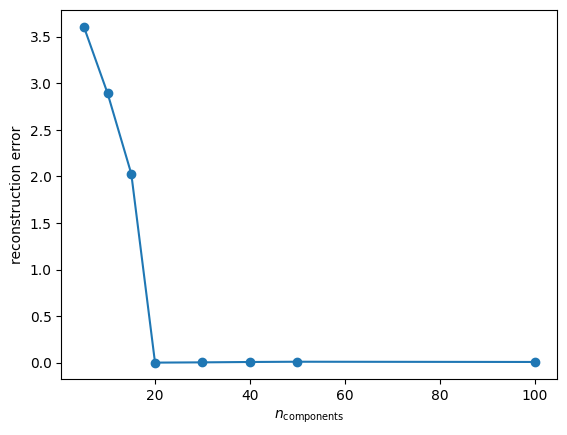

In [230]:
n_components = [5, 10, 15, 20, 30, 40, 50, 100]
errors = []
for n_component in n_components:
    nmf_ = NMF(n_component, max_iter=10000)
    nmf_.fit(tf_idf_df)
    errors.append(nmf_.reconstruction_err_)
plt.plot(n_components, errors, '-o')
plt.xlabel(r'$n_\text{components}$')
plt.ylabel('reconstruction error');

In [231]:
# Instantiate the NMF model & specify the number of topics
# Set random_state for reproducibility
n_topics = len(f_cat_id)  # best_k
nmf_model = NMF(n_components=n_topics, random_state=1).set_output(transform="pandas")

# Fit the NMF model to the TF-IDF matrix
# Note that the 'H' matrix (topic-term distribution) is in nmf_model.components_
# Note that the 'W' matrix (document-topic distribution) can be obtained with model.transform(tfidf_matrix)
nmf_model.fit(tf_idf_df)

# Function to print the top words for each topic (from search results)
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(nmf_model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [232]:
# Print the top words per topic from search results
# print_top_words(nmf_model, feature_names, topic_no) # uncomment when using topic_no 
print_top_words(nmf_model, feature_names, 10)

Topic #0:
penguin readers classics classic speaking contemporary years seventy translators disciplines
Topic #1:
introduction story human novel based victor literary epic battle timeless
Topic #2:
emma husband dreams love forever family reality captive mannarrates enemy
Topic #3:
soon scientific wells essay influential blood caused prendick experiments biographical
Topic #4:
years man translations global speaking contemporary translators seventy disciplines authoritative
Topic #5:
novel wells time considers scientists search afraid tunnels descended people
Topic #6:
men stop translation secret adventure earth encounter new describing published
Topic #7:
washington post book search future novel dystopian time powerful journalist
Topic #8:
russia george orwell individual dystopian powerful dreams journalist novel worst
Topic #9:
awake trance earth troubled prescient uneducated desperately fascinating greed comes
Topic #10:
invisible griffin kemp wells mind struggle horror introduction ex

In [233]:
# Get the document-topic distribution
document_topic = nmf_model.transform(tf_idf_df)
document_topic

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


,nmf0,nmf1,nmf2,nmf3,nmf4,nmf5,nmf6,nmf7,nmf8,nmf9,...,nmf247,nmf248,nmf249,nmf250,nmf251,nmf252,nmf253,nmf254,nmf255,nmf256
0,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.000000e+00,0.000017,4.984706e-02,0.000000,0.000000,...,0.001313,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000
1,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.127807,0.000000,...,0.131929,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000
2,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000
3,0.000000,0.000000,0.00000,0.000000e+00,0.000000,5.809140e-08,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.339261
4,0.268618,0.000000,0.00000,0.000000e+00,0.003549,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000666,0.000000,0.000000,2.211583e-06,0.002315,0.000000,0.127408,0.0,0.000000
5,0.073719,0.000000,0.00000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.015242e-06,0.000000,0.000000,0.000000,0.0,0.000000
6,0.175015,0.000000,0.00000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.403446e-05,0.005383,0.000000,0.000000,0.0,0.000000
7,0.081553,0.000000,0.00000,0.000000e+00,0.027251,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.004405,0.147773,0.000000,3.439245e-06,0.004832,0.000000,0.000000,0.0,0.000000
8,0.138812,0.000005,0.00000,0.000000e+00,0.000958,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.019217,1.238319,0.002140,0.000000e+00,0.003358,0.000000,0.000000,0.0,0.000000
9,0.245918,0.000000,0.00000,0.000000e+00,0.000000,0.000000e+00,0.000016,0.000000e+00,0.000000,0.000000,...,0.000349,0.000000,0.000000,0.000000,0.000000e+00,0.011522,0.000000,0.000000,0.0,0.000000


## Semantic Ranking Using Cosine Similarity

Cosine similarity measures the angular distance between the query’s projected topic vector and each book’s topic vector from the NMF model

This produces relevance scores and enables ranking the entire catalog by semantic similarity to the user’s query.

A reusable query function is implemented:

>Input: A natural-language text query

>Processing: TF-IDF transform → NMF projection → cosine similarity scoring

>Output: Top-10 semantically relevant book titles with metadata

This module forms the end-user interface for book discovery.

#### Step 4. Create a query function

In [234]:
# Get top words per topic from search results
n_top_words = 10
topic_dict = {}
for topic_idx, topic in enumerate(nmf_model.components_):
        topic_dict[topic_idx] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
topic_dict

{0: ['penguin',
  'readers',
  'classics',
  'classic',
  'speaking',
  'contemporary',
  'years',
  'seventy',
  'translators',
  'disciplines'],
 1: ['introduction',
  'story',
  'human',
  'novel',
  'based',
  'victor',
  'literary',
  'epic',
  'battle',
  'timeless'],
 2: ['emma',
  'husband',
  'dreams',
  'love',
  'forever',
  'family',
  'reality',
  'captive',
  'mannarrates',
  'enemy'],
 3: ['soon',
  'scientific',
  'wells',
  'essay',
  'influential',
  'blood',
  'caused',
  'prendick',
  'experiments',
  'biographical'],
 4: ['years',
  'man',
  'translations',
  'global',
  'speaking',
  'contemporary',
  'translators',
  'seventy',
  'disciplines',
  'authoritative'],
 5: ['novel',
  'wells',
  'time',
  'considers',
  'scientists',
  'search',
  'afraid',
  'tunnels',
  'descended',
  'people'],
 6: ['men',
  'stop',
  'translation',
  'secret',
  'adventure',
  'earth',
  'encounter',
  'new',
  'describing',
  'published'],
 7: ['washington',
  'post',
  'book',
 

In [235]:
# Identify topics that contain the words in the query
query = 'Science Fiction'

search_topic_list = []
for word in query.lower().split():
    counter = 0
    for topic in topic_dict.values():
        if word in topic:
            search_topic_list.append(counter)
        counter += 1

search_topic_list

[11,
 32,
 38,
 46,
 94,
 105,
 167,
 199,
 205,
 212,
 219,
 234,
 249,
 253,
 18,
 30,
 55,
 73,
 75,
 76,
 94,
 149,
 155,
 167,
 190,
 196,
 205,
 209,
 212,
 214,
 219,
 226,
 233,
 237,
 245,
 247,
 254,
 256]

In [236]:
# Create a dataframe that contains all relevant topics
working_df = pd.DataFrame(document_topic.iloc[:, search_topic_list])
# working_df.set_index(corpus['isbn'], inplace=True)

# Get the total row score for each isbn
working_df['score'] = working_df.iloc[:, 0:].sum(axis=1)
working_df

result = working_df.sort_values(axis=0, by='score', ascending=False).head(10)
result = result[result['score'] > 0]
result

,nmf11,nmf32,nmf38,nmf46,nmf94,nmf105,nmf167,nmf199,nmf205,nmf212,...,nmf214,nmf219,nmf226,nmf233,nmf237,nmf245,nmf247,nmf254,nmf256,score
19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.738556
14,0.000000,0.000000,0.000000,0.000197,0.000000,0.000000,0.931444,0.018391,0.420848,0.005963,...,0.000000,0.000000,0.011424,0.000000,0.000000,0.000000,0.000000,0.000000,0.590992,4.710648
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.090322,0.015254,0.000000,0.224156,0.000000,...,0.000000,0.000000,0.000000,0.003723,0.058619,0.000000,0.131929,0.000000,0.000000,2.871346
12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000324,0.403386,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.466486
8,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007013,...,0.000000,0.086802,0.000000,0.000589,0.000002,0.000009,0.000000,0.000000,0.000000,2.201139
7,0.000000,0.000000,0.000000,0.000000,0.184349,0.000000,0.126196,0.264499,0.000000,0.000000,...,0.000000,0.000027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.107652
4,0.000000,0.000000,0.017961,0.000000,0.000000,0.000000,0.000000,0.076602,0.000000,0.087851,...,0.000000,0.000000,0.000000,0.024139,0.000000,0.000000,0.000000,0.127408,0.000000,1.836682
3,0.000000,0.000000,0.000000,0.239567,0.000000,0.000000,0.106111,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.050621,0.000000,0.000000,0.000000,0.000000,0.339261,1.214483
9,0.213557,0.039081,0.000000,0.000039,0.000022,0.000000,0.072023,0.243997,0.000000,0.011196,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000349,0.000000,0.000000,0.851253
10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008650,0.000000,...,0.001402,0.000000,0.000000,0.003264,0.000770,0.000137,0.000000,0.000000,0.138466,0.824821


#### Cosine Similarity Query

In [237]:
from sklearn.metrics.pairwise import cosine_similarity

def nmf_query_search(query, tfidf, nmf, W, top_k=10):

    # 1. Transform query using the SAME TF-IDF model
    q_tfidf = tfidf.transform([query])

    # 2. Project query into SAME NMF topic space
    q_vec = nmf.transform(q_tfidf)

    # 3. Cosine similarity
    sims = cosine_similarity(q_vec, W).ravel()

    # 4. Sort
    top_idx = sims.argsort()[::-1][:top_k]

    return top_idx, sims[top_idx]


In [269]:
idx, scores =  nmf_query_search(query=query, tfidf=vectorizer, nmf=nmf_model, W=document_topic, top_k=10)
# idx, scores
q_result = corpus.iloc[idx][['isbn', 'title', 'description']]
q_result

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(


,isbn,title,description
3,9780140296549,No,A compelling novel based on the high-stakes bi...
4,9780140431063,The Science Fiction of Edgar Allan Poe,"One of the greatest of all horror writers, Edg..."
12,9780141439983,The Invisible Man,Depicting one man's transformation and descent...
1,9780140185850,We,The exhilarating dystopian novel that inspired...
14,9780141441030,The War of the Worlds,"The first modern tale of alien invasion, H.G. ..."
7,9780141182087,R.U.R. (Rossum's Universal Robots),A visionary work of science fiction that intro...
9,9780141394930,Twenty Thousand Leagues Under the Sea,"Vernes timeless underwater adventure story, no..."
2,9780140234640,Heroes and Villains,"After the apocalypse, society is divided into ..."
10,9780141439471,Frankenstein,The worlds most famous work of horror fiction:...
8,9780141196428,The Purple Cloud,The first great science fiction novel of the t...


In [264]:
def get_title_categories(isbn):
    params = {
        "api_key": API_KEY,
        "catSetId": "BI",
    }
    cat_url = f"{TITLE_CAT}{isbn}/categories"
    r = session.get(cat_url, params=params, timeout=20)
    print(r)
    print("STATUS:", r.status_code)
    print("URL:", r.url)
    print("RAW:", r.text[:250])

    result = dict(r.json())['data']['categories']
    out = []
    for entry in result:
        out.append(entry['catId'])

    r.raise_for_status()
    return out

In [265]:
isbn = q_result.iloc[0]['isbn']
isbn

9780140296549

In [270]:
get_title_categories(isbn)

<Response [200]>
STATUS: 200
URL: https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/9780140296549/categories?api_key=fh5hj47dynk4nvx4s9ewufj4&catSetId=BI
RAW: {"status":"ok","recordCount":4,"startTimestamp":"2025-11-22T11:50:26Z","endTimestamp":"2025-11-22T11:50:26Z","timeTaken":9,"data":{"categories":[{"catId":3000001525,"description":"Fiction","catSetId":"BI","catUri":"FIC000000","menuText":"Fiction","ha


[3000001525, 3000001666, 3000001670, 3000001784]

In [271]:
def build_catid_confusion_matrix(q_result, target_catid):
    """
    q_result: DataFrame containing ISBNs in column 'isbn'
    target_catid: int, the catId to evaluate

    Returns:
        confusion matrix (DataFrame with rows=Actual, cols=Predicted)
    """

    isbns = q_result["isbn"].tolist()

    rows = []

    for isbn in isbns:
        # Now returns a LIST of catIds
        cat_ids = get_title_categories(isbn)

        # Check if the target category is present
        has_cat = int(target_catid in cat_ids)

        rows.append({"isbn": isbn, "has_cat": has_cat})

    df = pd.DataFrame(rows)

    # All items in q_result are predicted relevant (1)
    df["predicted"] = 1

    # Build confusion matrix
    confusion = pd.crosstab(
        df["has_cat"],
        df["predicted"],
        rownames=["Actual"],
        colnames=["Predicted"]
    )

    return df, confusion

In [272]:
build_catid_confusion_matrix(q_result, 3000001784)

<Response [200]>
STATUS: 200
URL: https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/9780140296549/categories?api_key=fh5hj47dynk4nvx4s9ewufj4&catSetId=BI
RAW: {"status":"ok","recordCount":4,"startTimestamp":"2025-11-22T11:50:26Z","endTimestamp":"2025-11-22T11:50:26Z","timeTaken":9,"data":{"categories":[{"catId":3000001525,"description":"Fiction","catSetId":"BI","catUri":"FIC000000","menuText":"Fiction","ha
<Response [200]>
STATUS: 200
URL: https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/9780140431063/categories?api_key=fh5hj47dynk4nvx4s9ewufj4&catSetId=BI
RAW: {"status":"ok","recordCount":4,"startTimestamp":"2025-11-22T12:08:28Z","endTimestamp":"2025-11-22T12:08:28Z","timeTaken":9,"data":{"categories":[{"catId":3000001525,"description":"Fiction","catSetId":"BI","catUri":"FIC000000","menuText":"Fiction","ha
<Response [200]>
STATUS: 200
URL: https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/9780141439983/cate

(            isbn  has_cat  predicted
 0  9780140296549        1          1
 1  9780140431063        1          1
 2  9780141439983        1          1
 3  9780140185850        1          1
 4  9780141441030        1          1
 5  9780141182087        1          1
 6  9780141394930        1          1
 7  9780140234640        1          1
 8  9780141439471        1          1
 9  9780141196428        1          1,
 Predicted   1
 Actual       
 1          10)